
<!-- README.md is generated from README.ipynb. Please edit that file -->

# pyramid-learn <img src="docs/logo/logo_banner.png" align="right" height="65"/>

A Python wrapper for the ['midr'](https://ryo-asashi.github.io/midr/) R package to explain black-box models, with a scikit-learn compatible API.

The goal of 'midr' and 'pyramid-learn' is to provide a model-agnostic
method for interpreting and explaining black-box predictive models by
creating a globally interpretable surrogate model. The package implements
'Maximum Interpretation Decomposition' (MID), a functional decomposition
technique that finds an optimal additive approximation of the original
model. This approximation is achieved by minimizing the squared error
between the predictions of the black-box model and the surrogate model.
The theoretical foundations of MID are described in Iwasawa & Matsumori
(2025) \[Forthcoming\], and the package itself is detailed in [Asashiba
et al. (2025)](https://arxiv.org/abs/2506.08338).

## Installation

You can install the package directly from GitHub:

```bash
pip install git+https://github.com/ryo-asashi/pyramid-learn.git
```

## Features

- **Scikit-learn Compatible API**: Fits seamlessly into your existing 'scikit-learn' workflows with a familiar .fit() and .predict() interface.

- **Model-Agnostic IML**: Explains any black-box model, from complex neural networks to gradient boosting machines.

- **Global Interpretability**: Generates a simple, additive surrogate model (MID) that provides a global understanding of the black-box model's behavior.

- **Direct Visualizations**: Easily creates plots for feature importance, component functions (dependence), prediction breakdowns, and conditional expectations using a plotnine-based interface.

## Requirements

This package is a rpy2-based Python wrapper and requires a working R installation on your system, as well as the 'midr' R package.

You can install the R package from CRAN by running the following command in your R console:

```r
install.packages('midr')
```

## Quick Start

Here’s a basic example of how to use pyramid-learn, or `midlearn`, to explain a trained LightGBM model.

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing

import lightgbm as lgb
import midlearn as mid # pyramid-learn

import plotnine as p9
p9.theme_set(p9.theme_bw())

In [13]:
from sklearn import set_config

# Change the display to simple text instead of an HTML diagram
set_config(display='text')

### Train a black-box model

In [3]:
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = housing.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Fit a LightGBM regression model
estimator = lgb.LGBMRegressor(random_state=42)
estimator.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 15480, number of used features: 8
[LightGBM] [Info] Start training from score 2.070349


LGBMRegressor(random_state=42)

### Use pyramid-learn to explain the model

In [4]:
# Fit a MID model as a global surrogate explainer
explainer = mid.MIDExplainer(
    estimator=estimator,
    interaction=True,
    params_main=50,
    penalty=.01
)
explainer.fit(X_train)

Generating predictions from the estimator...


MIDExplainer(estimator=LGBMRegressor(random_state=42), params_main=50,
             penalty=0.01)

Generating predictions from the estimator...
R-squared score: 0.9535885334150813


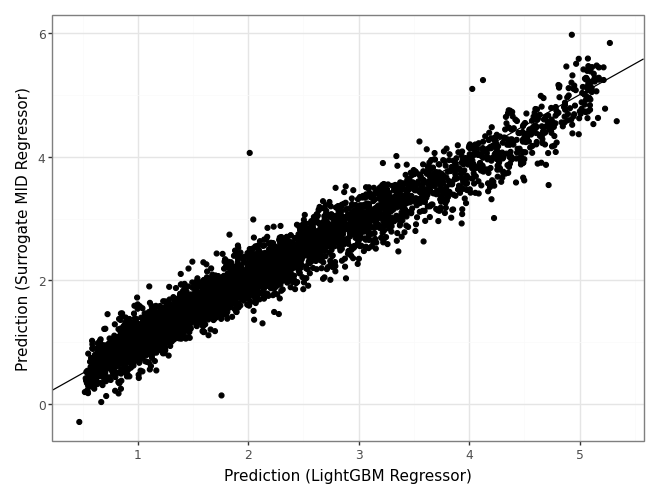

In [5]:
# Check the fidelity of the surrogate model to the original model
print("R-squared score:", explainer.fidelity_score(X_test))

p = p9.ggplot() \
    + p9.geom_abline(slope=1) \
    + p9.geom_point(p9.aes(estimator.predict(X_test), explainer.predict(X_test))) \
    + p9.labs(
        x='Prediction (LightGBM Regressor)',
        y='Prediction (Surrogate MID Regressor)'
    )
display(p)

### Visualize and analyze the results

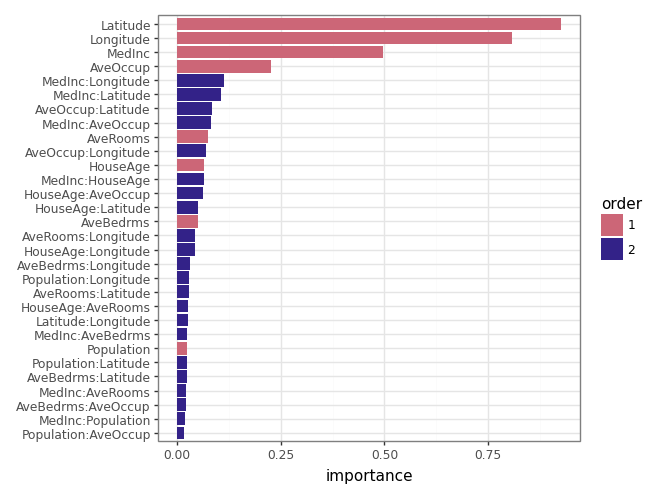

In [6]:
# Plot overall feature importance
imp = explainer.importance()
imp.plot(theme='muted')

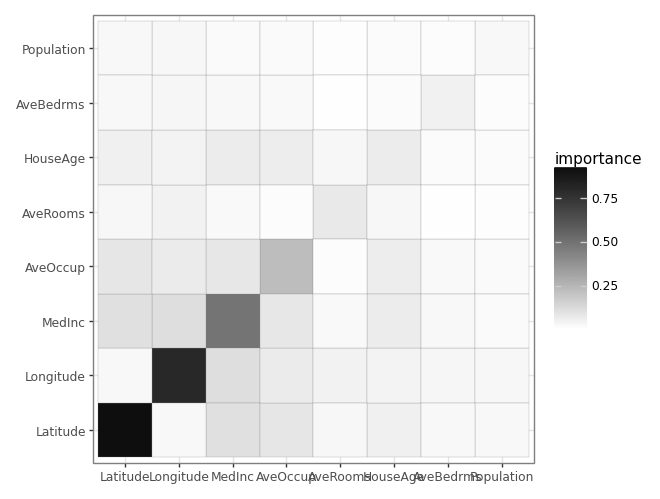

In [7]:
# Plot overall feature importance as a heatmap
imp.plot(style='heatmap', color='#808080')

1: Latitude


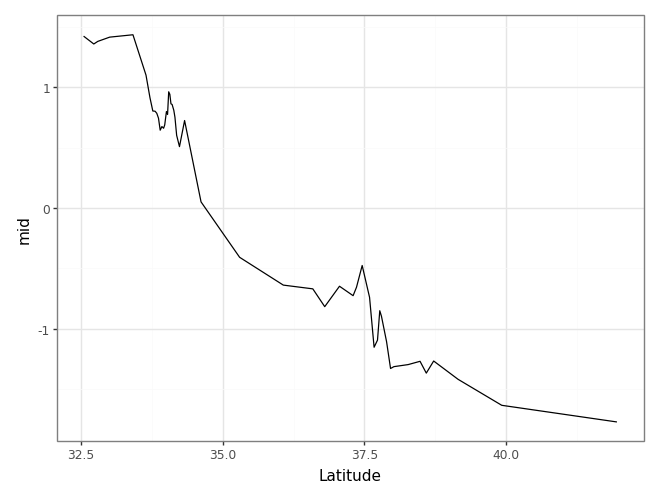

2: Longitude


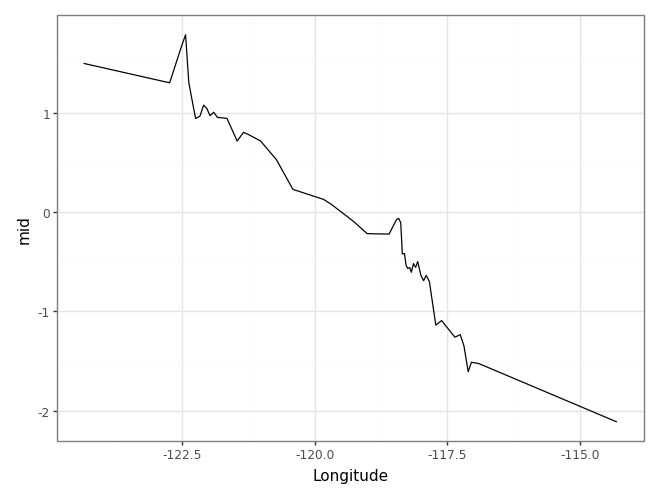

3: MedInc


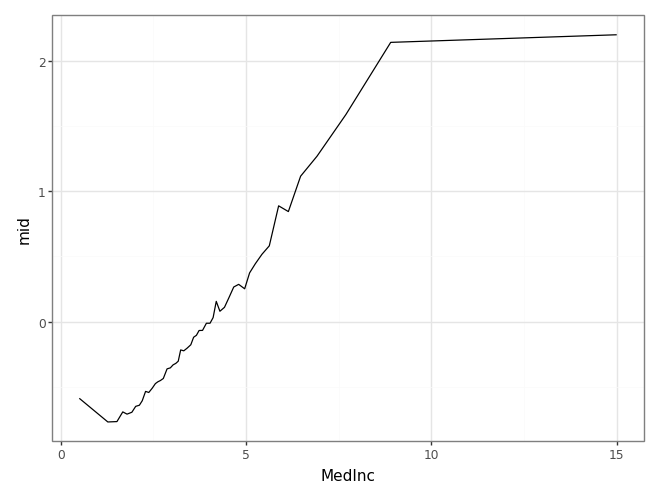

In [8]:
# Plot important main effects
for i, t in enumerate(imp.terms(interactions=False)[:3]):
    print(f"{i + 1}: {t}")
    display(explainer.plot(term=str(t)))

1: MedInc:Longitude


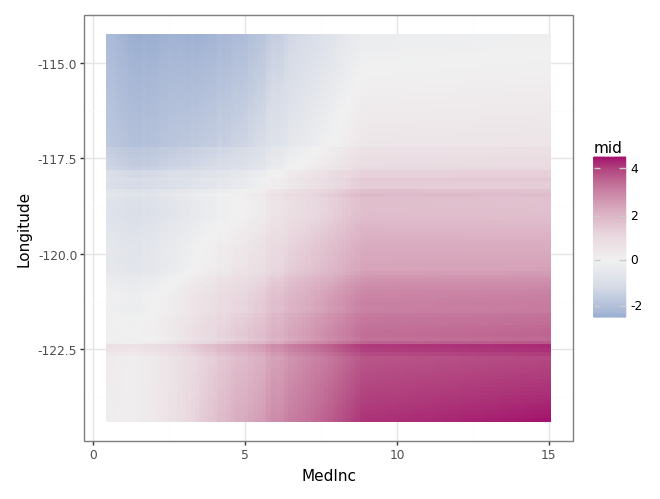

2: MedInc:Latitude


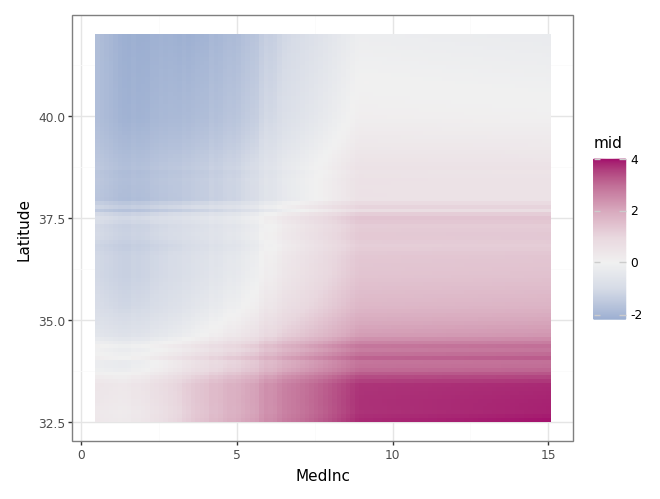

3: AveOccup:Latitude


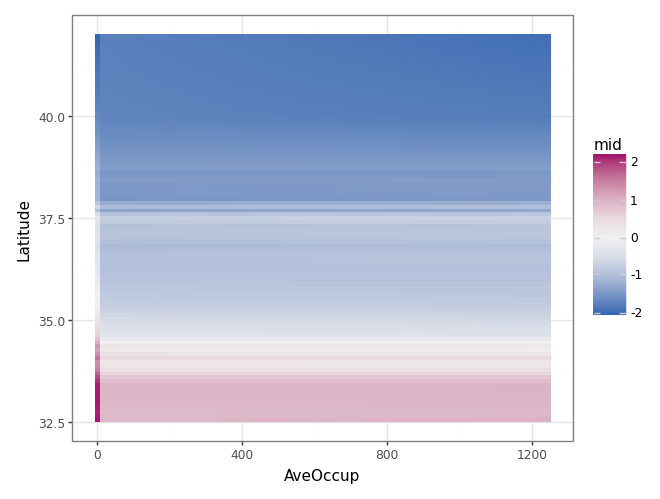

In [9]:
# Plot important two-way interactions (with main effects)
for i, t in enumerate(imp.terms(main_effects=False)[:3]):
    print(f"{i + 1}: {t}")
    display(explainer.plot(term=str(t), main_effects=True))

row 0


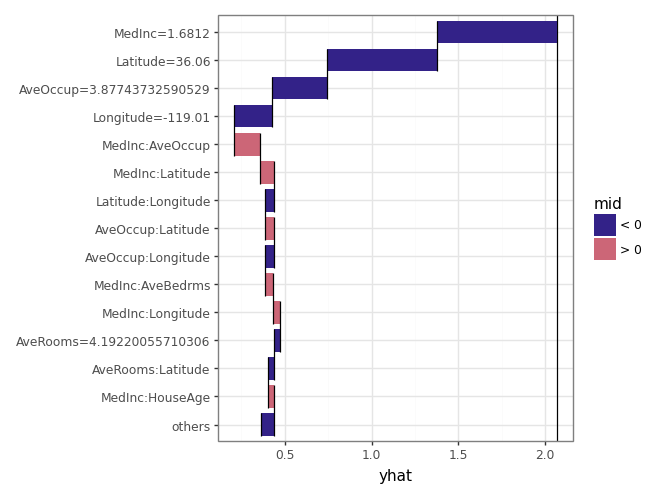

row 1


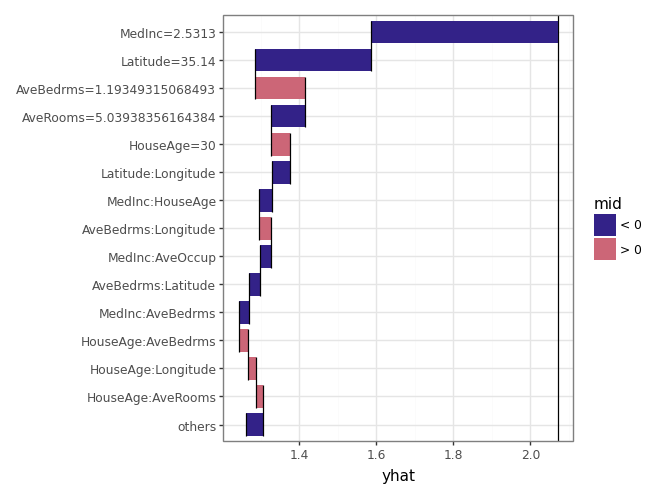

row 2


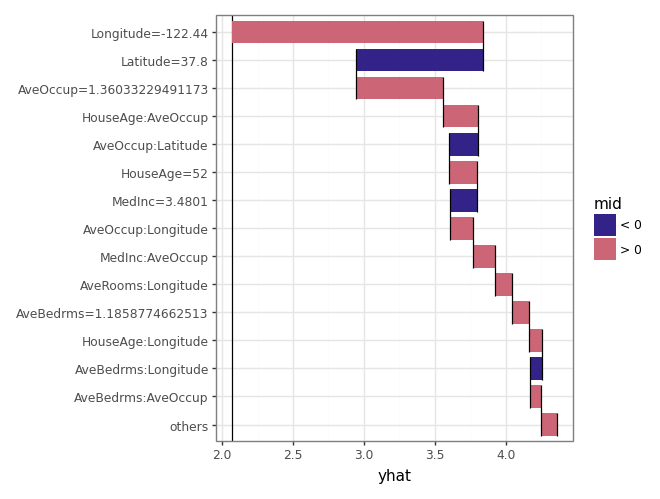

In [10]:
# Plot prediction breakdowns for the first three rows in the testing dataset
for i in range(3):
    print(f"row {i}")
    display(explainer.breakdown(row=i, data=X_test).plot(theme='muted_r'))

R callback write-console: the number of evaluation points exceeds the limit: the data is reduced to 1000 observations
  


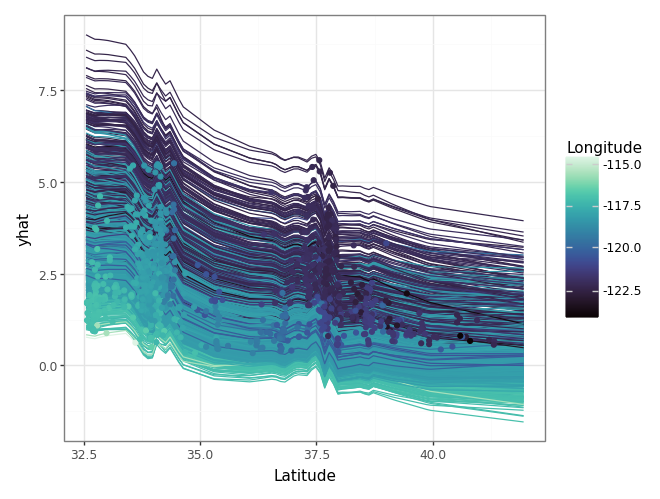

In [11]:
# Plot individual conditional expectations
explainer.conditional('Latitude').plot(var_color='Longitude', theme='mako')